<a href="https://colab.research.google.com/github/abdussahid26/GPT-Model-from-Scratch-to-Generate-Text/blob/main/GPT_Model_to_Generate_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementing a GPT model from scratch to generate text**

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

**GPT Architecture Part-1: Dummy GPT model class**

In [2]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

The code above is already functional, as we will see later in this section after we prepare the input data.

However, for now, note in the code above that we have used placeholders (DummyLayerNorm and DummyTransformerBlock) for the transformer block and layer normalization, which we will develop in later sections

Next, we will prepare the input data and initialize a new GPT model to illustrate its usage.

**Step-1: Tokenization**

In [3]:
!pip install tiktoken

In [4]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2") # BPE tokenizer
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch = []
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)

print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


**Step-2: Create an instance of DUMMYGPTMODEL**

In [5]:
torch.manual_seed(123)
model1 = DummyGPTModel(GPT_CONFIG_124M)
logits = model1(batch)

print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


The output tensor has two rows corresponding to the two text samples. Each text sample consists of 4 tokens; each token is a 50,257-dimensional vector, which matches the size of the tokenizer's vocabulary.

**GPT Architecture Part-2: Layer Normalization**

Explanation with a simple example.

In [6]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5) # Creates two training examples with five dimensions (features) each.
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU()) # Implement a neural network layer with five inputs and six outputs.
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


The neural network layer we have coded consists of a Linear layer followed by a nonlinear activation function, ReLU (short for rectified linear unit), which is a standard activation function in neural networks. If you are unfamiliar with ReLU, it simply thresholds negative inputs to 0, ensuring that a layer outputs only positive values, which explains why the resulting layer output does not contain any negative values. Later, we will use another, more sophisticated activation function in GPT.

Before we apply layer normalization to these outputs, let’s examine the mean and variance.

In [7]:
# The dim parameter specifies the dimension along which the calculation of
# the statistic (here, mean or variance) should be performed in a tensor.

mean = out.mean(dim=-1, keepdim=True) # dim=-1 specifies that mean across the last dimension
var = out.var(dim=-1, keepdim=True) # dim=-1 specifies that variance across the last dimension

print("Mean: \n", mean)
print("Variance: \n", var)

Mean: 
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


The first row in the mean tensor here contains the mean value for the first input row, and the second output row contains the mean for the second input row. Using keepdim=True in operations like mean or variance calculation ensures that the output tensor retains the same number of dimensions as the input tensor, even though the operation reduces the tensor along the dimension specified via dim. For instance, without keepdim=True, the returned mean tensor would be a two-dimensional vector [0.1324, 0.2170] instead of a 2 × 1–dimensional matrix [[0.1324], [0.2170]].

In [8]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)

print("Normalized layer outputs: \n", out_norm)
print("Mean: \n", mean)
print("Variance: \n", var)

Normalized layer outputs: 
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean: 
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


To improve readability, we can also turn off the scientific notation when printing tensor values by setting sci_mode to False.

In [9]:
import torch

torch.set_printoptions(sci_mode=False)

print("Mean: \n", mean)
print("Variance: \n", var)

Mean: 
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Let's now encapsulate this process in a PyTorch module that we can use in the GPT model later.

In [10]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)

        return self.scale * norm_x + self.shift


This specific implementation of layer normalization operates on the last dimension of the input tensor x, which represents the embedding dimension (emb_dim). The variable eps is a small constant (epsilon) added to the variance to prevent division by zero during normalization. The scale and shift are two trainable parameters (of the same dimension as the input) that the LLM automatically adjusts during training if it is determined that doing so would improve the model’s performance on its training task. This allows the model to learn appropriate scaling and shifting that best suit the data it is processing.

A small note on *Bias Variance*:

In our variance calculation method, we use an implementation detail by setting unbiased=False. For those curious about what this means, in the variance calculation, we divide by the number of inputs n in the variance formula. This approach does not apply Bessel’s correction, which typically uses n – 1 instead of n in the denominator
to adjust for bias in sample variance estimation. This decision results in a socalled biased estimate of the variance. For LLMs, where the embedding dimension n is significantly large, the difference between using n and n – 1 is practically negligible.
I chose this approach to ensure compatibility with the GPT-2 model’s normalization layers and because it reflects TensorFlow’s default behavior, which was used to implement the original GPT-2 model.

Let's now try the LayerNorm module in practice and apply it to the batch input.

In [11]:
ln = LayerNorm(emb_dim = 5)
out_ln = ln(batch_example)

mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean: \n", mean)
print("Variance: \n", var)

Mean: 
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


The results show that the layer normalization code works as expected and normalizes the values of each of the two inputs such that they have a mean of 0 and a variance of 1.

**GPT Architecture Part-3: Feed Forward Neural Network with GELU Activation**

Let's implement the GELU activation function approximation used by GPT-2.

In [12]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

To get an idea of what this GELU function looks like and how it compares to the ReLU function, let’s plot these functions side by side

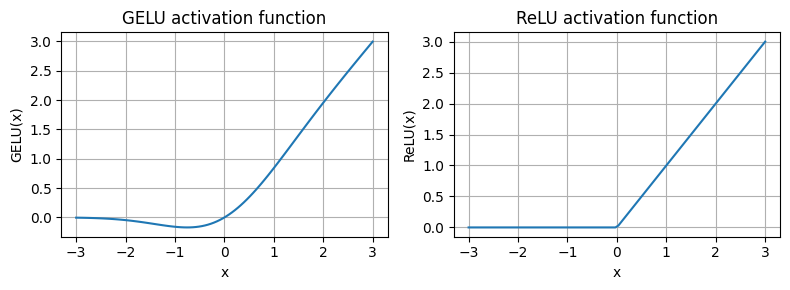

In [13]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate (zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

The smoothness of GELU can lead to better optimization properties during training, as it allows for more nuanced adjustments to the model’s parameters. In contrast, ReLU has a sharp corner at zero, which can sometimes make optimization harder, especially in networks that are very deep or have complex architectures. Moreover, unlike ReLU, which outputs zero for any negative input, GELU allows for a small, non-zero output for negative values. This characteristic means that during the training process, neurons that receive negative input can still contribute to the learning process, albeit to a lesser extent than positive inputs.

Let’s use the GELU function to implement the small neural network module, FeedForward, that we will be using in the LLM’s transformer block later.

In [14]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

Let’s initialize a new FeedForward module with a
token embedding size of 768 and feed it a batch input with two samples and three tokens each.

In [15]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) # Creates a sample input with batch dimension 2
out = ffn(x)

print(out.shape)


torch.Size([2, 3, 768])


The FeedForward module plays a crucial role in enhancing the model’s ability to learn from and generalize the data. Although the input and output dimensions of this module are the same, it internally expands the embedding dimension into a higher dimensional space through the first linear layer. This expansion is followed by a nonlinear GELU activation and then a contraction back to the original
dimension with the second linear transformation. Such a design allows for the exploration of a richer representation space.

Moreover, the uniformity in input and output dimensions simplifies the architecture by enabling the stacking of multiple layers, as we will do later, without the need to adjust dimensions between them, thus making the model more scalable.

**GPT Architecture Part-3: Adding Shortcut Connections**

In [16]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


The code implements a deep neural network with 5 layers, each consisting of a Linear layer and a GELU activation function.

In the forward pass, we iteratively pass the input through the layers and optionally add the shortcut connections if the self.use_shortcut attribute is set to True.

Let's use this code to first initialize a neural network without shortcut connections. Here, each layer will be initialized such that it accepts an example with 3 input values and returns 3 output values. The last layer returns a single output value.

In [17]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123) # specify random seed for the initial weights for reproducibility
model_without_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=False
)

Next, we implement a function that computes the gradients in the the model's backward.


In [18]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target and output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [19]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


The output of the print_gradients function shows, the gradients become smaller as we progress from the last layer (layers.4) to the first layer (layers.0), which is a phenomenon called the vanishing gradient problem.

Let’s now instantiate a model with skip connections and see how it compares.

In [20]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


The last layer (layers.4) still has a larger gradient than the other layers. However, the gradient value stabilizes as we progress toward the first layer (layers.0) and doesn’t shrink to a vanishingly small value.

**GPT Architecture Part-5: Connecting attention and linear layers
in a transformer block**

Let us code a transformer block as follows:

In [21]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out) # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
    def forward(self, x):
        b, num_tokens, d_in = x.shape # Shape: (batch, num_tokens, d_in)
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a 'num_heads' dimension
        # Unroll last dim: (batch, num_tokens, d_out) -> (batch, num_tokens, num_tokens, head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (batch, num_tokens, num_heads, head_dim) -> (batch, num_heads, num_tokens, head_dim)
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3) # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (batch, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [22]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x) # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut # Add the original input back

        return x

The given code defines a TransformerBlock class in PyTorch that includes a multi-head attention mechanism (MultiHeadAttention) and a feed forward network (Feed-Forward), both configured based on a provided configuration dictionary (cfg), such as GPT_CONFIG_124M.
Layer normalization (LayerNorm) is applied before each of these two components, and dropout is applied after them to regularize the model and prevent overfitting. This is also known as Pre-LayerNorm. Older architectures, such as the original transformer model, applied layer normalization after the self-attention and feed forward networks instead, known as Post-LayerNorm, which often leads to worse training dynamics.

The class also implements the forward pass, where each component is followed by a shortcut connection that adds the input of the block to its output. This critical feature helps gradients flow through the network during training and improves the learning of deep models.

In [23]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768) # 2 batches, 4 tokens, and each token is 768 dimensions

block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape : ", x.shape)
print("Output shape: ", output.shape)

Input shape :  torch.Size([2, 4, 768])
Output shape:  torch.Size([2, 4, 768])


As we can see, the transformer block maintains the input dimensions in its output, indicating that the transformer architecture processes sequences of data without altering their shape throughout the network. The preservation of shape throughout the transformer block architecture is not incidental but a crucial aspect of its design. This design enables its effective application across a wide range of sequence-to-sequence tasks, where each output vector
directly corresponds to an input vector, maintaining a one-to-one relationship. However, the output is a context vector that encapsulates information from the entire input sequence. This means that while the physical dimensions of the sequence (length and feature size) remain unchanged as it passes through the transformer
block, the content of each output vector is re-encoded to integrate contextual information from across the entire input sequence.

**GPT Architecture Part-6: Implementing the entire GPT model**

In [24]:
import torch
import torch.nn as nn

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias = False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        # The device setting will allow us to train the model on a CPU or GPU, depending on which device the input data sits on.
        pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

Let’s now initialize the 124-million-parameter GPT model using the GPT_CONFIG_124M dictionary we pass into the cfg parameter and feed it with the batch text input we created earlier.

In [25]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out=model(batch)

print("Input batch: \n", batch)
print("\nOutput shape: ", out.shape)
print(out)


Input batch: 
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape:  torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


the output tensor has the shape [2, 4, 50257], since we passed in two
input texts with four tokens each. The last dimension, 50257, corresponds to the vocabulary size of the tokenizer. Later, we will see how to convert each of these 50,257-dimensional output vectors back into tokens.

Before we move on to coding the function that converts the model outputs into text, let’s spend a bit more time with the model architecture itself and analyze its size. Using the numel() method, short for “number of elements,” we can collect the total number of parameters in the model’s parameter tensors:

In [26]:
total_params = sum(p.numel() for p in model.parameters())

print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


Now, a curious reader might notice a discrepancy. Earlier, we spoke of initializing a 124-million-parameter GPT model, so why is the actual number of parameters 163 million?

The reason is a concept called weight tying, which was used in the original GPT-2 architecture. It means that the original GPT-2 architecture reuses the weights from the token embedding layer in its output layer. To understand better, let’s take a look at the shapes of the token embedding layer and linear output layer that we initialized on the model via the GPTModel earlier.

In [27]:
print("Token embedding layer shape: ", model.tok_emb.weight.shape)
print("Output layer shape: ", model.out_head.weight.shape)

Token embedding layer shape:  torch.Size([50257, 768])
Output layer shape:  torch.Size([50257, 768])


The token embedding and output layers are very large due to the number of rows for the 50,257 in the tokenizer's vocabulary. Let's remove the output layer parameter count from the total GPT-2 model count according to the weight tying.

In [28]:
total_params_gpt2 = (
    total_params - sum(p.numel()
    for p in model.out_head.parameters())
)

print(f"Number of trainable parameters "
    f"after weight tying: {total_params_gpt2:,}"
)

Number of trainable parameters after weight tying: 124,412,160


As we can see, the model is now only 124 million parameters large, matching the original size of the GPT-2 model. Weight tying reduces the overall memory footprint and computational complexity of the model.

Let's compute the memory requirements of the 163 million parameters in our GPTModel object.



In [29]:
total_size_bytes = total_params * 4 # Calculates the total size in bytes(assuming float32, 4 bytes per parameter)
total_size_mb = total_size_bytes / (1024 * 1024) # Converts to megabytes

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


**GPT Architecture Part-7: Generating Text from Output Tokens**

In [30]:
# idx is a (batch, n_tokens) array of indices in the current context
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g. if LLM supports only 5 tokens, and the context size is 10
        # then only last 5 tokens are used as context.
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) # dimension of logits tensor: [batch, num_tokens, vocabulary_size]

        # Focuses only on the last row, so that (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]
        # Probs has shape (batch, vocab_size)
        # Apply softmax to get probabilities
        probs = torch.softmax(logits, dim=-1)
        # idx_next has shape(batch, 1)
        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probs, dim=-1, keepdim=True)
        # Append sample index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

Let’s now try out the generate_text_simple function with the "Every effort moves you" context as model input. First, we encode the input context into token IDs.

In [31]:
start_context = "Every effort moves you"
encoded = tokenizer.encode(start_context)
print("encoded: ", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Adds batch dimension
print("encoded_tensor.shape: ", encoded_tensor.shape)

encoded:  [6109, 3626, 6100, 345]
encoded_tensor.shape:  torch.Size([1, 4])


Next, we put the model into .eval() mode. This disables random components like dropout, which are only used during training, and use the generate_text_simple function on the encoded input tensor.

In [32]:
model.eval() # Disables dropout since we are not training the model

out = generate_text_simple(
    model = model,
    idx = encoded_tensor,
    max_new_tokens = 6,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("Output: ", out)
print("Output length: ", len(out[0]))

Output:  tensor([[ 6109,  3626,  6100,   345, 37532, 24086, 47843, 30961, 42348, 15635]])
Output length:  10


Using the .decode method of the tokenizer, we can convert the IDs back into text.

In [33]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Every effort moves you Aeiman Byeswickattributeometer


As we can see, the model generated gibberish, which is not at all like the coherent text **Every effort moves you forward**. What happened? The reason the model is unable to produce coherent text is that we haven’t trained it yet. So far, we have only implemented the GPT architecture and initialized a GPT model instance with initial random weights.
Model training is a large topic in itself, and we will tackle it further.

**Using GPT to generate text**

In [34]:
import torch

GPT_CONFIG_124M_Short = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256,  # We shorten the context length from 50257 to 256
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False       # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval(); # Disable dropout during inference

we have reduced the context length (context_length) to 256 tokens. This modification reduces the computational demands of training the model, making it possible to carry out the training on a standard laptop computer. Originally, the GPT-2 model with 124 million parameters was configured to handle up to 1,024 tokens.

In [35]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M_Short["context_length"]
)

print("Output text: ", token_ids_to_text(token_ids, tokenizer))

Output text:  Every effort moves you Aeiman Byeswickattributeometer inspector Normandy freezerigrate


Clearly, the model isn’t yet producing coherent text because it hasn’t undergone training. To define what makes text “coherent” or “high quality,” we have to implement a numerical method to evaluate the generated content. This approach will enable us to monitor and enhance the model’s performance throughout its training proces. Next, we will calculate a loss metric for the generated outputs. This loss serves as a progress and success indicator of the training progress.

**Calculating the text generation loss: cross-entroy and perplexity**

In the following hands-on code, we will work with two input examples for the GPT model ("every effort moves" and "I really like"). Consider these two input examples, which have already been mapped to token IDs.

In [36]:
inputs = torch.tensor([[16833, 3626, 6100], # ["Every effort moves",
                       [40,    1107, 588]   # "I really like"]
                      ])
targets = torch.tensor([[3626, 6100, 345],  # ["effort moves you",
                        [1107, 588,  11311] # "really like chocolate"]
                       ])

Note that the targets are the inputs but shifted one position forward. This shifting strategy is crucial for teaching the model to predict the next token in a sequence.

Now we feed the inputs into the model to calculate logits vectors for the two input examples, each comprising three tokens. Then we apply the softmax function to transform these logits into probability scores.

In [37]:
with torch.no_grad(): # Disable gradient tracking since we are not training yet.
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


The first number, 2, corresponds to the two examples (rows) in the inputs, also known as batch size. The second number, 3, corresponds to the number of tokens in each input (row). Finally, the last number corresponds to the embedding dimensionality, which is determined by the vocabulary size. Following the conversion from logits to probabilities via the softmax function, the generate_text_simple function then converts the resulting probability scores back into text. By applying the argmax function to the probability scores to obtain the corresponding token IDs.

In [38]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True) # dim=-1 means specified operation will perform along the column
print("Token IDs: \n", token_ids)

Token IDs: 
 tensor([[[36397],
         [39619],
         [20610]],

        [[ 8615],
         [49289],
         [47105]]])


Let's converts the token IDs back into text.

In [39]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Gathering SerbianFriday


The model produces random text that is different from the target text because it has not been trained yet. We now want to evaluate the performance of the model’s generated text numerically via a loss. Not only is this useful for measuring
the quality of the generated text, but it’s also a building block for implementing the training function, which we will use to update the model’s weight to improve the generated text.

**Cross-entropy loss**

For each of the two input texts, we can print the initial softmax probability scores corresponding to the target tokens using the following code.

In [40]:
text_idx = 0 # looking at batch 1; [0, 1, 3] means row 0, 1, and 2.
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([    0.0000,     0.0000,     0.0000])
Text 2: tensor([    0.0000,     0.0000,     0.0000])


The goal of training an LLM is to maximize the likelihood of the correct token, which involves increasing its probability relative to other tokens. This way, we ensure the LLM consistently picks the target token—essentially the next word in the sentence—as the next token it generates.

In [41]:
# Compute logarithm of all token probabilities

log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([-10.6600, -10.7936, -11.3531, -10.0591, -11.0276, -11.3658])


In [42]:
# Calculate the average log probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.8765)


The goal is to get the average log probability as close to 0 as possible by updating the model’s weights as part of the training process. However, in deep learning, the common practice isn’t to push the average log probability up to 0 but rather to bring the
negative average log probability down to 0. The negative average log probability is simply the average log probability multiplied by –1.

In [43]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.8765)


In deep learning, the term for turning this negative
value, –10.8765, into 10.8765, is known as the cross entropy loss.

Before we apply the buitin cross_entropy function by PyTorch, let’s briefly recall the shape of the logits and target tensors.

In [44]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape: ", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape: ", targets.shape)

Logits shape:  torch.Size([2, 3, 50257])
Targets shape:  torch.Size([2, 3])


For the cross_entropy loss function in PyTorch, we want to flatten these tensors by combining them over the batch dimension.

In [45]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


Remember that the targets are the token IDs we want the LLM to generate, and the logits contain the unscaled model outputs before they enter the softmax function to obtain the probability scores.
Previously, we applied the softmax function, selected the probability scores corresponding to the target IDs, and computed the negative average log probabilities. PyTorch’s cross_entropy function will take care of all these steps for us.

In [46]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.8765)


**Perplexity**

The perplexity is simply the exponential of the cross-entropy loss.

In [47]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(52918.7773)


Perplexity is often considered more interpretable than the raw loss value because it signifies the effective vocabulary size about which the model is uncertain at each step. In the given example, this would translate to the model being unsure about which among
52,918 tokens in the vocabulary to generate as the next token.

**Calculating the training and validation set loses**

In [48]:
import os
import urllib.request

url = "https://raw.githubusercontent.com/abdussahid26/Dara-preparation-and-sampling-for-LLMs/main/the-verdict.txt"

file_path = "the-verdict.txt"
urllib.request.urlretrieve(url, file_path)

with open("the-verdict.txt", "r", encoding="utf-8") as f:
    text_data = f.read()

print("Print first 100 characters: \n", text_data[:99])
print("Print last 100 characters: \n", text_data[-99:])

Print first 100 characters: 
 I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 
Print last 100 characters: 
 it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [49]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data)) # BPE tokenizer

print("Characters: ", total_characters)
print("Tokens: ", total_tokens)

Characters:  20479
Tokens:  5145


With just 5,145 tokens, the text might seem too small to train an LLM, but as mentioned earlier, it’s for educational purposes so that we can run the code in minutes instead of weeks. Plus, later we will load pretrained weights from OpenAI into our GPTModel code.
Next, we divide the dataset into a training and a validation set and use the data loaders from chapter 2 to prepare the batches for LLM training. Due to spatial constraints, we use a max_length=6. However, for the actual data loaders, we set the max_length equal to the 256-token context length that the LLM supports so that the LLM sees longer texts during training.

To implement the data splitting and loading, we first define a train_ratio to use 90% of the data for training and the remaining 10% as validation data for model evaluation during training.

In [50]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


In [51]:
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride): # max_length means context_size;  the stride determines how much we slide during applying sliding window approach
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt) # Tokenizes the entire text

        for i in range(0, len(token_ids) - max_length, stride): # Uses a sliding window approach to chunk the book into overlapping sequences of max_length
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self): # Returns the total number of rows in the dataset
        return len(self.input_ids)

    def __getitem__(self, idx): # Returns a single row from the dataset
        return self.input_ids[idx], self.target_ids[idx]

In [52]:
# batch_size: The dataset usually chunked into batches. batch_size=4 means after analyzing 4 batches the model updats its parameter.
# num_workers means the number of CPU threads will be used for parallel processing.

def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2") # Initializes the BPE tokenizer.
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride) # It creates an instance of the GPTDatasetV1.
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last, # drop_last = True; drops the last batch if it is shorter than the specified batch_size to prevent loss spikes during training.
        num_workers=num_workers # The number of CPU processes to use for preprocessing.
    )

    return dataloader

In [53]:
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M_Short["context_length"],
    stride=GPT_CONFIG_124M_Short["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)


val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M_Short["context_length"],
    stride=GPT_CONFIG_124M_Short["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [54]:
print("Train loader: ")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader: ")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader: 
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader: 
torch.Size([2, 256]) torch.Size([2, 256])


Based on the preceding code output, we have nine training set batches with two samples and 256 tokens each. Since we allocated only 10% of the data for validation, there is only one validation batch consisting of two input examples.


Next, we implement a utility function to calculate the cross entropy loss of a given batch returned via the training and validation loader.

In [55]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()


print("Training tokens: ", train_tokens)
print("Validation tokens: ", val_tokens)
print("All tokens: ", train_tokens + val_tokens)

Training tokens:  4608
Validation tokens:  512
All tokens:  5120


In [56]:
def calc_loss_batch(input_batch, target_batch, model, device):
    # The transfer to a given device allows us to transfer the data to a GPU
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())

    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader) # Iterate over all batches if no fixed num_batches is specified
    else:
        # Reduces the number of batches to match the total number of batches in the data loader if
        # num_batches exceeds the number of batches in the data loader.
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches # Averages the loss over all batches

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # If you have a machine with a CUDA-supported GPU, the LLM will train on the GPU without making any changes to the code.
with torch.no_grad(): # Disables gradient tracking for efficiency because we are not training yet.
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)


Training loss: 10.988501654730904
Validation loss: 10.99034309387207


The loss values are relatively high because the model has not yet been trained. For comparison, the loss approaches 0 if the model learns to generate the next tokens as they appear in the training and validation sets. Now that we have a way to measure the quality of the generated text, we will train the LLM to reduce this loss so that it becomes better at generating text.

**Pretraining the Above GPTModel**

The following train_model_simple is the main function for pretaining LLMs.

In [58]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    # Initializes lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Starts the main training loop
    for epoch in range(num_epochs):
        model.train() # Sets the model to the training mode
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients w.r.t all of the 162M parameters for GPT-2
            optimizer.step() # Updates model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch + 1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )
        # Print a sample text after each epoch
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

Note that the train_model_smaple function we just created uses two functions we have not defined yet: evaluate_model and generate_and_print sample. The evaluate_model function prints the training and validation set losses after each model update so we can evaluate whether the training improves the model. More specifically, the evaluate_model function calculates the loss over the training and validation set while ensuring the model is in evaluation mode with gradient tracking and dropout disabled when calculating the loss over the training and validation sets.

In [59]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() # Dropout is disabled during evaluation for stable, reproducible results
    with torch.no_grad(): # Disables gradient tracking, which is not required during evaluation, to reduce the computational overhead
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
        model.train()
        return train_loss, val_loss

The generate_and_print_sample function is a convenience function that we use to track whether the model improves during the training. In particular, the generate_and_print_sample function takes a text snippet (start_context) as input, converts it into token IDs, and feeds it to the LLM to generate a text sample using the generate_text_simple function we used earlier.

In [60]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " ")) # Compact print format
    model.train()

Let's see this all in action by training a GPTModel instance for 10 epochs using an AdamW optimizer and the train_model_simple function we defined earlier.

In [61]:
import time

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M_Short)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004,
    weight_decay=0.1
)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs = num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Epoch 1 (Step 000000): Train loss 9.783, Val loss 9.927
Epoch 1 (Step 000005): Train loss 7.985, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
Epoch 2 (Step 000010): Train loss 6.753, Val loss 7.048
Epoch 2 (Step 000015): Train loss 6.114, Val loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
Epoch 3 (Step 000020): Train loss 5.525, Val loss 6.490
Epoch 3 (Step 000025): Train loss 5.324, Val loss 6.387
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
Epoch 4 (Step 000030): Train loss 4.761, Val loss 6.360
Epoch 4 (Step 000035): Train loss 4.461, Val loss 6.258
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
Epoch 5 (Step 000040): Train loss 3.833, Val loss 

As we can see, the training loss improves drastically, starting with a value of 9.783 and converging to 0.506. The language skills of the model have improved quite a lot. In the beginning, the model is only able to append commas to the start context (Every effort moves you,,,,,,,,,,,,) or repeat the word and. At the end of the
training, it can generate grammatically correct text. Similar to the training set loss, we can see that the validation loss starts high
(9.927) and decreases during the training. However, it never becomes as small as the training set loss and remains at 6.325 after the 10th epoch.


Let's create a simple plot that shows the training and validation set losses side by side.

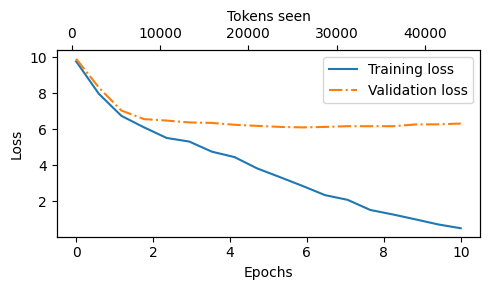

In [62]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny() # Creates a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0) # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

As we can see, both the training and validation losses start to improve for the first epoch. However, the losses start to diverge past the second epoch. This divergence and the fact that the validation loss is much larger than the training loss indicate that the model is overfitting to the training data. We can confirm that the model memorizes the training data verbatim by searching for the generated text snippets, such as "quite insensible to the irony" in the "The Verdict" text file. This memorization is expected since we are working with a very, very small training dataset and training the model for multiple epochs. Usually, it's common to train a model on a much larger dataset for only one epoch.

*Next, we'll cover text generation strategies for LLMs to reduce training data memorization  and increase the originality of the LLM-generated text.*